In [156]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
import math
from tqdm import tqdm
from importlib import reload

torch.manual_seed(1337)

In [157]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
device

'cpu'

In [158]:
class Config():
    def __init__(self, context_size, batch_size):
        self.n_layers = 1
        self.n_heads = 4
        self.embed_size = 8
        self.context_size = context_size
        self.batch_size = batch_size


In [159]:
config = Config(
    context_size = 16,
    batch_size = 64
)

In [160]:
import utils.preprocess as pp
reload(pp)

dataset = pp.ShortSequenceDataset('data/restriction-sites.txt',
    context_size=config.context_size, batch_size=config.batch_size
).to(device)
config.vocab_size = len(dataset.vocab)
config.init_code = dataset.init_code

data_train, data_test = torch.utils.data.random_split(dataset, [0.9, 0.1])
(len(data_train), len(data_test))

(411, 45)

In [161]:
data_train[0:10]

(tensor([[30, 30, 30, 30, 30, 30, 30, 19, 19,  4, 17, 19, 17, 19, 17, 17],
         [30, 30, 30, 30, 30, 30, 17, 26, 17, 15, 19,  1, 14,  4, 12,  2],
         [30, 30, 30, 30, 30, 30, 30, 30, 30, 19, 26, 23,  4, 23, 15, 17],
         [30, 30, 30, 30, 30, 30, 30, 30, 30, 19, 19, 19, 17, 17,  4, 17],
         [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 17,  4, 17, 19, 19],
         [30, 30, 30, 30, 30, 30, 30, 30, 30, 19,  4, 19, 17, 19, 17, 17],
         [30, 30, 30, 30, 30, 30, 17, 17, 26, 26, 17,  1, 11,  4, 10,  2],
         [30, 30, 30, 30, 30, 30, 30, 30, 30, 17,  4, 29, 17, 19, 24, 19],
         [30, 30, 30, 30, 30, 30, 30, 30, 30, 26,  4, 19, 15, 26, 17, 15],
         [30, 30, 30, 17, 17, 17, 15, 19, 17,  1,  3, 10,  4,  3,  6,  2]]),
 tensor([[30, 30, 30, 30, 30, 30, 19, 19,  4, 17, 19, 17, 19, 17, 17,  0],
         [30, 30, 30, 30, 30, 17, 26, 17, 15, 19,  1, 14,  4, 12,  2,  0],
         [30, 30, 30, 30, 30, 30, 30, 30, 19, 26, 23,  4, 23, 15, 17,  0],
         [30, 30, 30, 3

In [162]:
( dataset.decode(dataset[7][0]), dataset.decode(dataset[7][1]) )

('^^^^^^^^^A/CCGGT', '^^^^^^^^A/CCGGT$')

In [163]:
class AttentionHead(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        embed_size = config.embed_size
        context_size = config.context_size
        # key, query, value projecions for all attention heads
        self.kqv = nn.Linear(embed_size, 3*embed_size, bias=False)
        # output projection
        self.output = nn.Linear(embed_size, embed_size, bias=False)
        # mask out upper diagonal
        self.register_buffer("mask", torch.tril(torch.ones(context_size, context_size))
            .view(1, 1, context_size, context_size))

    def forward(self, X):
        # batch size, sequence length, and embedding dimensionality
        B, T, D = X.shape

        embed_size = self.config.embed_size
        n_heads = self.config.n_heads

        # (B, D, 3*D)  -> (B, D, D)
        # multiple each weight matrix with data and split
        query, key, value = self.kqv(X).split(embed_size, dim=2)
        # (B, D, D) -> (B, H, T, D/H)
        key = key.view(B, T, n_heads, D // n_heads).transpose(1, 2)  
        query = query.view(B, T, n_heads, D // n_heads).transpose(1, 2)  
        value = value.view(B, T, n_heads, D // n_heads).transpose(1, 2)  

        # (B, H, T, D/H) @ (B, H, D/H, T) -> (B, H, T, T)
        att = (query @ key.transpose(-2, -1)) / math.sqrt(key.size(-1))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = fn.softmax(att, dim=-1)

        # (B, H, T, T) @ (B, H, T, D/H) -> (B, H, T, D/H)
        Y = att @ value

        # re-assemble outputs from all heads
        Y = Y.transpose(1, 2).contiguous().view(B, T, D)

        # linear map of all heads together
        Y = self.output(Y)
        return Y

class Feedforward(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        embed_size = config.embed_size
        self.hidden1 = nn.Linear(embed_size, 4*embed_size)
        self.gelu = nn.GELU()
        self.hidden2 = nn.Linear(4*embed_size, embed_size)
    
    def forward(self, X):
        X = self.hidden1(X)
        X = self.gelu(X)
        X = self.hidden2(X)
        return X

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.attend = AttentionHead(config)
        self.feed = Feedforward(config)

    def forward(self, X):
        X = X + self.attend(X)
        X = X + self.feed(X)
        return X

In [164]:
class GPT(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embed = nn.Embedding(config.vocab_size, config.embed_size)
        self.pos_embed = nn.Embedding(config.context_size, config.embed_size)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layers)])
        self.unembed = nn.Linear(config.embed_size, config.vocab_size, bias=False)

    def forward(self, X, Y=None):
        # X is (B, T), Y is (B, T)
        pos = torch.arange(0, X.shape[1], dtype=torch.long)
        
        token_embeds = self.token_embed(X)  # (B, T, D)
        pos_embeds = self.pos_embed(pos)    # (B, T, D)
        embeds = token_embeds + pos_embeds

        for block in self.blocks:
            embeds = block(embeds)

        logits = self.unembed(embeds)  # (B, T, C)

        # tie the unembedding weights to the embedding weights
        # linear function transposes the weight
        #logits = fn.linear(embeds, self.token_embed.weight)

        if Y is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            Y = Y.view(B*T)
            loss = fn.cross_entropy(logits, Y)
        
        return logits, loss

    @torch.no_grad()
    def sample(self, n, X=None, temperature=1.0):
        """
        Generate n new token codes given context X.
        """
        if X is None:
            X = torch.tensor([[config.init_code]])
        for _ in range(n):
            if X.size(1) > self.config.context_size:
                # sequence context is too long; crop it to context_size
                X_cropped = X[:, -self.config.context_size:]
            else:
                X_cropped = X
            # get prediction
            logits, _ = self(X_cropped)
            # get last time step and scale by temperature
            logits = logits[:, -1, :] / temperature
            probs = fn.softmax(logits, dim=1)  # (B, C)
            x_new = torch.multinomial(probs, num_samples=1)
            X = torch.cat((X, x_new), dim=1)   # (B, T+1)
        return X[0, ]

In [165]:
model = GPT(config).to(device)

In [166]:
batch = data_train[0:3]
logits, loss = model(batch[0], batch[1])
print(loss)
dataset.decode( model.sample(8) )

tensor(3.4100, grad_fn=<NllLossBackward0>)


'^3BMS/V/1'

In [167]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [176]:
loader = torch.utils.data.DataLoader(data_train,
    batch_size=config.batch_size, num_workers=1, shuffle=True)

losses_train = []
losses_test = []

n_epochs = 500
for epoch in tqdm(range(n_epochs)):
    # iterate through training data
    model.train()
    for step, batch in enumerate(loader):
        X, Y = batch
        # evaluate loss
        logits, loss = model(X, Y)
        # backpropagation of errors
        loss.backward()
        # update weights
        optim.step()
        # clear gradient
        optim.zero_grad(set_to_none=True)
        losses_train.append(loss.item())
    # evaluate test loss
    model.eval()
    X, Y = data_test[:]
    logits, loss_test = model(X, Y)
    losses_test.append(loss_test.item())

print(f"loss: (train: {losses_train[-1]}, test: {losses_test[-1]})")

100%|██████████| 500/500 [00:27<00:00, 18.34it/s]

loss: (train: 0.9727771282196045, test: 0.9168062806129456)


In [177]:
dataset.decode( model.sample(16) )

'^^^^^^^^^^GC/ACA$'

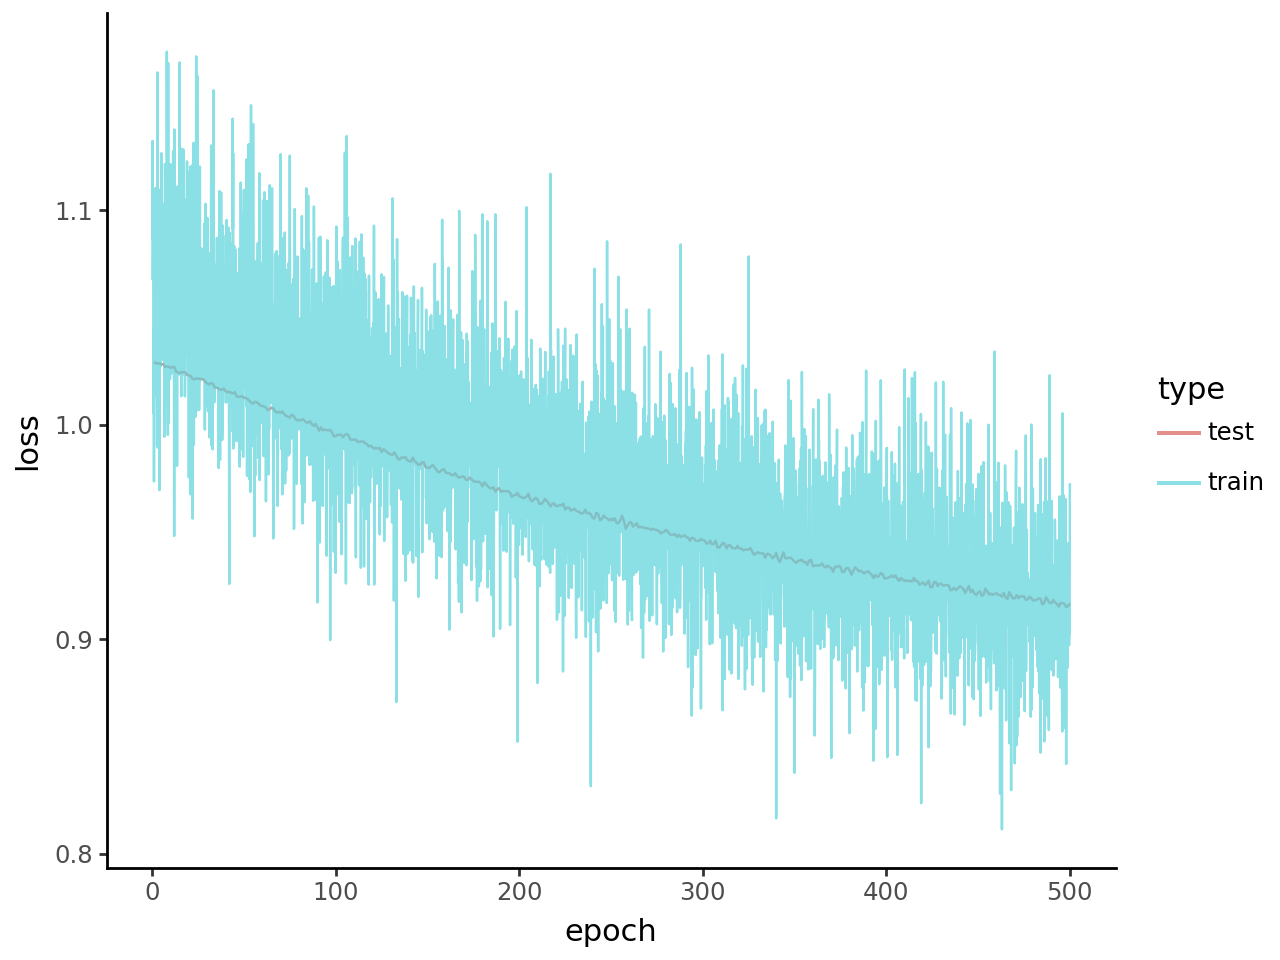

In [187]:
from plotnine import ggplot, geom_line, aes, theme_classic, scale_color_discrete
import pandas as pd

epochs = [i for i in range(1, len(losses_test)+1)]
epochs_train = [i * len(losses_test) / len(losses_train) for i in range(1, len(losses_train)+1)]

losses_pd = pd.concat([
    pd.DataFrame({
        'epoch': epochs_train,
        'loss': losses_train,
        'type': 'train'
    }),
    pd.DataFrame({
        'epoch': epochs,
        'loss': losses_test,
        'type': 'test'
    }),
])

(ggplot(losses_pd, aes(x='epoch', y='loss', colour='type')) + 
    geom_line(alpha=0.7) +
    theme_classic())